In [1]:
from main import main
from PDconfig import LaVoz
from frames.archivosDF import *

main()
ruta_barrios = './DataFrames/LaVoz/barrios.csv'
ruta_ciudades = './DataFrames/LaVoz/ciudades.csv'
df = abrirDF(LaVoz)

In [2]:
# Completar datos:
filt = df["terrenoEdificado"].isna() & df["tipoPropiedad"] == "DEPARTAMENTO"
df.loc[filt, "terrenoEdificado"] = df.loc[filt, "terrenoTotal"]

In [3]:
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df = df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado', 'cantDormitorios', 'cantBanos', 'cantCochera'])

# CAMBIAR TIPOS PROP
reemplazos = {
  "DUPLEX" : "CASA",
  "DÚPLEX" : "CASA",
  "TRIPLEX" : "CASA",
  "CHALET" : "CASA", 
  "PREFABRICADA": "CASA", 
  "CABAÑA" : "CASA",
  "SEMIPISO" : "DEPARTAMENTO",
  "PISO" : "DEPARTAMENTO",
  "PENTHOUSE" : "DEPARTAMENTO",
  "LOFT" : "DEPARTAMENTO"
}
df["tipoPropiedad"].replace(reemplazos, inplace= True)

filt = df['tipoVendedor'] != 'Inmobiliaria'
df.loc[filt, 'tipoVendedor'] = 'PARTICULAR'
# ELIMINAR TIPO PROP INSERVIBLES
filt = (df["tipoPropiedad"] == "CASA") | (df["tipoPropiedad"] == "DEPARTAMENTO") | (df["tipoPropiedad"] == "TERRENOS LOTES")
df = df.loc[filt]

# SEPARAR TERRENOS/LOTES DEL RESTO
terrenos = df.loc[df["tipoPropiedad"] == "TERRENOS LOTES"]
inmuebles = df.loc[df["tipoPropiedad"] != "TERRENOS LOTES"]

In [4]:
# FILTRADO DETALLADO INMUEBLES
filtro_TT = inmuebles["terrenoTotal"].between(inmuebles["terrenoTotal"].quantile(0.01179), 
                                          inmuebles["terrenoTotal"].quantile(0.992))
filtro_P = inmuebles["precioUSD"].between(inmuebles["precioUSD"].quantile(0.01179), 
                                          inmuebles["precioUSD"].quantile(0.992))
inmuebles_filt = inmuebles.loc[filtro_TT & filtro_P]

# Convert the 'fechaUltimaActualizacion' column to datetime objects
inmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], errors='coerce', format='mixed', dayfirst=True)
inmuebles_filt= inmuebles_filt[inmuebles_filt['fechaUltimaActualizacion'].dt.year == 2023]

# FILTRADO DETALLADO TERRENOS
filtro_TT = terrenos["terrenoTotal"].between(terrenos["terrenoTotal"].quantile(0.025), 
                                          terrenos["terrenoTotal"].quantile(0.99))
filtro_P = terrenos["precioUSD"].between(terrenos["precioUSD"].quantile(0.025), 
                                          terrenos["precioUSD"].quantile(0.99))

terrenos_filt = terrenos.loc[filtro_TT & filtro_P]

C:\Users\ihorrocks\AppData\Local\Temp\ipykernel_53064\334319019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], errors='coerce', format='mixed', dayfirst=True)


In [5]:
# Agrupar barrios
g_barrios = inmuebles_filt.groupby(['barrio', 'ciudad'])

# Calculamos Precio Promedio por barrio
costo_prom_barrio = g_barrios['precioUSD'].mean().round(0)
std_costo_barrio = g_barrios['precioUSD'].std().round(0)
costo_med_barrio = g_barrios['precioUSD'].median().round(0)

# Step 3: Calculate the cost per square meter ($/m2) for each group (including houses with barrio)
inmuebles_filt.loc[:, 'precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt.loc[:, 'precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

costo_prom_m2_tot_barrio = g_barrios['precio_m2_total'].mean().round(0)
costo_prom_m2_edif_barrio = g_barrios['precio_m2_edif'].mean().round(0)

std_costo_m2_tot_barrio = g_barrios['precio_m2_total'].std().round(0)
std_costo_m2_edif_barrio = g_barrios['precio_m2_edif'].std().round(0)

costo_med_m2_tot_barrio = g_barrios['precio_m2_total'].median().round(0)
costo_med_m2_edif_barrio = g_barrios['precio_m2_edif'].median().round(0)

# Step 4: Count the number of houses being sold in each group (including houses with barrio)
inmuebles_por_barrio = g_barrios.size()

# Add the results for barrio-level statistics to the city results
resultados_barrio = pd.DataFrame({
    'Costo Prom': costo_prom_barrio,
    'STD Costo' : std_costo_barrio,
    'Costo Med': costo_med_barrio,
    'Prom $/m2 Total': costo_prom_m2_tot_barrio,
    'STD $/m2 Total' : std_costo_m2_tot_barrio,
    'Med $/m2 Total': costo_med_m2_tot_barrio,
    'Prom $/m2 Edif': costo_prom_m2_edif_barrio,
    'STD $/m2 Edif' : std_costo_m2_edif_barrio,
    'Med $/m2 Edif': costo_med_m2_edif_barrio,
    'Cant': inmuebles_por_barrio
}).reset_index()

91


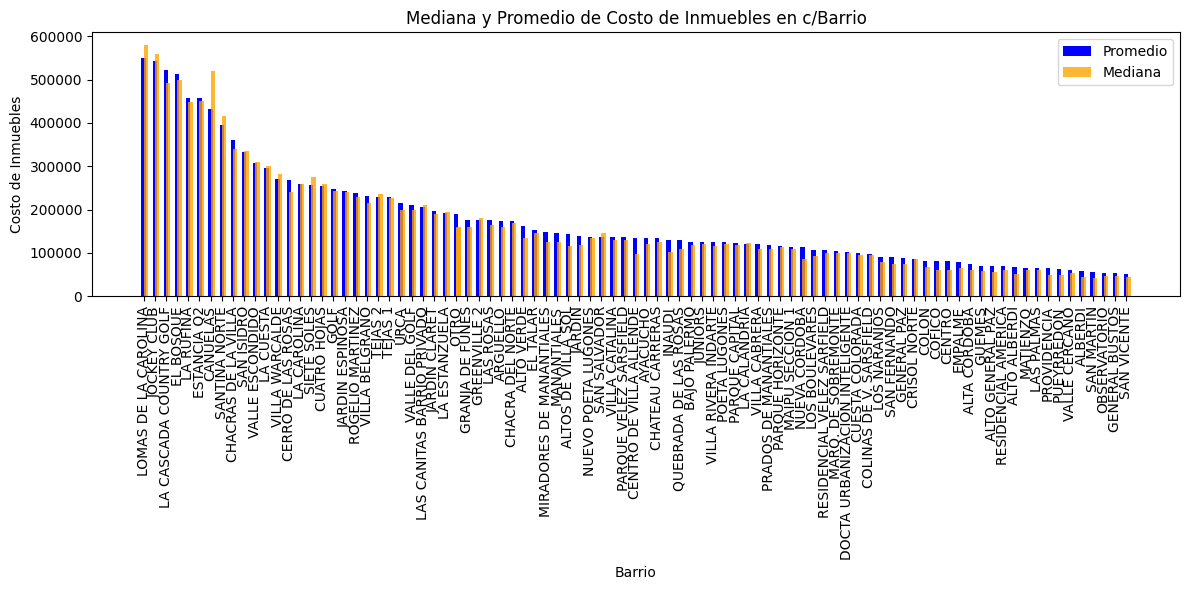

In [6]:
import matplotlib.pyplot as plt

resultados_barrio_sorted = resultados_barrio.sort_values(by='Costo Prom', ascending=False)
resultados_barrio_sorted = resultados_barrio_sorted.loc[resultados_barrio_sorted['Cant'] > 30]

plt.figure(figsize=(12, 6))
barrio_names = resultados_barrio_sorted['barrio']
print(len(barrio_names))
bar_width = 0.4

plt.bar(barrio_names, resultados_barrio_sorted['Costo Prom'], width=bar_width, label='Promedio', color='blue')

plt.bar(barrio_names, resultados_barrio_sorted['Costo Med'], width=bar_width, label='Mediana', color='orange', alpha=0.8, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('Costo de Inmuebles')
plt.title('Mediana y Promedio de Costo de Inmuebles en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
resultados_barrio_sorted[['barrio', 'Costo Prom', 'Costo Med']]

,barrio,Costo Prom,Costo Med
235,LOMAS DE LA CAROLINA,549609.0,580000.0
188,JOCKEY CLUB,542581.0,560000.0
200,LA CASCADA COUNTRY GOLF,522591.0,492500.0
126,EL BOSQUE,513544.0,500000.0
217,LA RUFINA,457639.0,447500.0
...,...,...,...
6,ALBERDI,57906.0,45000.0
385,SAN MARTIN,54887.0,43000.0
295,OBSERVATORIO,53584.0,47000.0
151,GENERAL BUSTOS,53300.0,46000.0


In [8]:
import pandas as pd

# Step 2: Calculate the price per squared meter ($/m²) for each group
inmuebles_filt['precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt['precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

# Step 1: Group the data by 'ciudad', 'barrio', and 'tipoPropiedad'
grouped_data = inmuebles_filt.groupby(['ciudad', 'barrio', 'tipoPropiedad'])

# Step 3: Calculate the mean price per squared meter for each group
precio_m2_total_mean = grouped_data['precio_m2_total'].mean().round(0)
precio_m2_total_median = grouped_data['precio_m2_total'].median().round(0)
precio_m2_edif_mean = grouped_data['precio_m2_edif'].mean().round(0)
precio_m2_edif_median = grouped_data['precio_m2_edif'].median().round(0)

# Step 4: Calculate the count of properties in each group
group_counts = grouped_data.size()

# Reset index to convert the grouped results to DataFrames
precio_m2_total_mean_df = precio_m2_total_mean.reset_index()
precio_m2_edif_mean_df = precio_m2_edif_mean.reset_index()
precio_m2_total_median_df = precio_m2_total_median.reset_index()
precio_m2_edif_median_df = precio_m2_edif_median.reset_index()

# Rename columns for clarity
precio_m2_total_mean_df.rename(columns={'precio_m2_total': 'Precio m2 Total Mean'}, inplace=True)
precio_m2_edif_mean_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Mean'}, inplace=True)
precio_m2_total_median_df.rename(columns={'precio_m2_total': 'Precio m2 Total Median'}, inplace=True)
precio_m2_edif_median_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Median'}, inplace=True)

# Step 5: Add the count column to each DataFrame
precio_m2_edif_median_df['Count'] = group_counts.values

# Step 6: Merge the results into a single DataFrame
merged_df = pd.merge(precio_m2_total_mean_df, precio_m2_edif_mean_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_total_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_edif_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])


merged_df["Total Delta"] = abs(merged_df["Precio m2 Total Mean"] - merged_df['Precio m2 Total Median'])
merged_df["Edif Delta"] = abs(merged_df["Precio m2 Edif Mean"] - merged_df['Precio m2 Edif Median'])


19


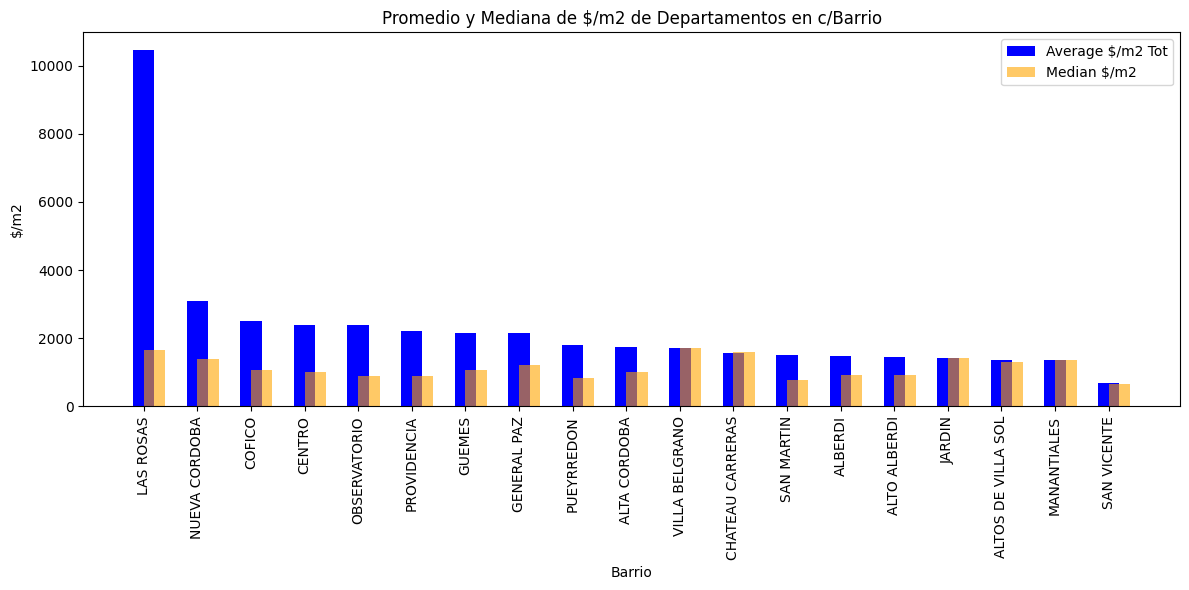

In [9]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
departamento_df = merged_df.sort_values("Precio m2 Total Mean", ascending=False)
departamento_df = departamento_df[(departamento_df['tipoPropiedad'] == 'DEPARTAMENTO') & (departamento_df["Count"] > 30)]
plt.figure(figsize=(12, 6))
barrio_names = departamento_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, departamento_df['Precio m2 Total Mean'], width=bar_width, label='Average $/m2 Tot', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, departamento_df['Precio m2 Total Median'], width=bar_width, label='Median $/m2', color='orange', alpha=0.6, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
departamento_df[['barrio', 'Precio m2 Total Mean', 'Precio m2 Total Median']]

,barrio,Precio m2 Total Mean,Precio m2 Total Median
271,LAS ROSAS,10452.0,1667.0
337,NUEVA CORDOBA,3086.0,1385.0
127,COFICO,2508.0,1081.0
106,CENTRO,2392.0,1000.0
348,OBSERVATORIO,2387.0,905.0
400,PROVIDENCIA,2208.0,887.0
198,GUEMES,2163.0,1071.0
187,GENERAL PAZ,2154.0,1222.0
404,PUEYRREDON,1802.0,825.0
18,ALTA CORDOBA,1742.0,1000.0


71


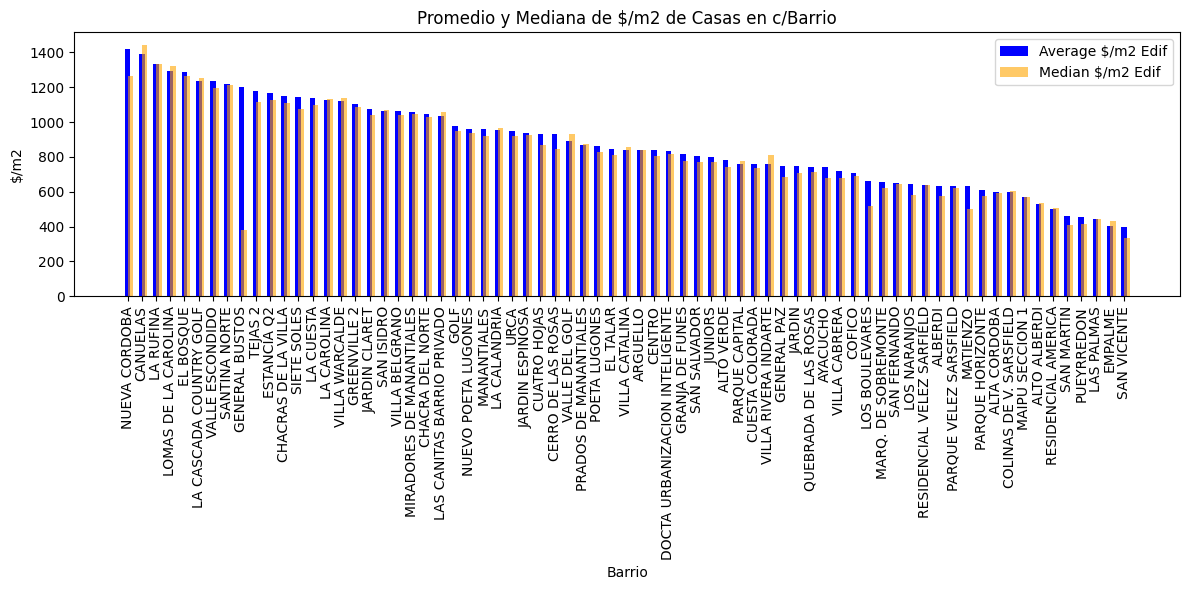

In [11]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
filt = (merged_df['tipoPropiedad'] == 'CASA') & (merged_df["Count"] > 30) & (merged_df['barrio'] != 'OTRO')
casa_df = merged_df.loc[filt].sort_values("Precio m2 Edif Mean", ascending=False)
plt.figure(figsize=(12, 6))
barrio_names = casa_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, casa_df['Precio m2 Edif Mean'], width=bar_width, label='Average $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, casa_df['Precio m2 Edif Median'], width=bar_width, label='Median $/m2 Edif', color='orange', alpha=0.6, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Casas en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
casa_df['prom'] = (casa_df['Precio m2 Edif Mean'] + casa_df['Precio m2 Edif Median'])/2
rank = casa_df[['barrio', 'prom']].head(30).reset_index()
rank

,index,barrio,prom
0,336,NUEVA CORDOBA,1344.0
1,93,CANUELAS,1417.0
2,613,LA RUFINA,1334.5
3,274,LOMAS DE LA CAROLINA,1308.5
4,160,EL BOSQUE,1278.0
5,243,LA CASCADA COUNTRY GOLF,1244.5
6,526,VALLE ESCONDIDO,1215.0
7,482,SANTINA NORTE,1218.0
8,183,GENERAL BUSTOS,789.5
9,505,TEJAS 2,1147.5


In [13]:
filt = inmuebles_filt["coordX"].notna() & (inmuebles_filt['tipoPropiedad'] == 'DEPARTAMENTO')
ubicados = inmuebles_filt.loc[filt]

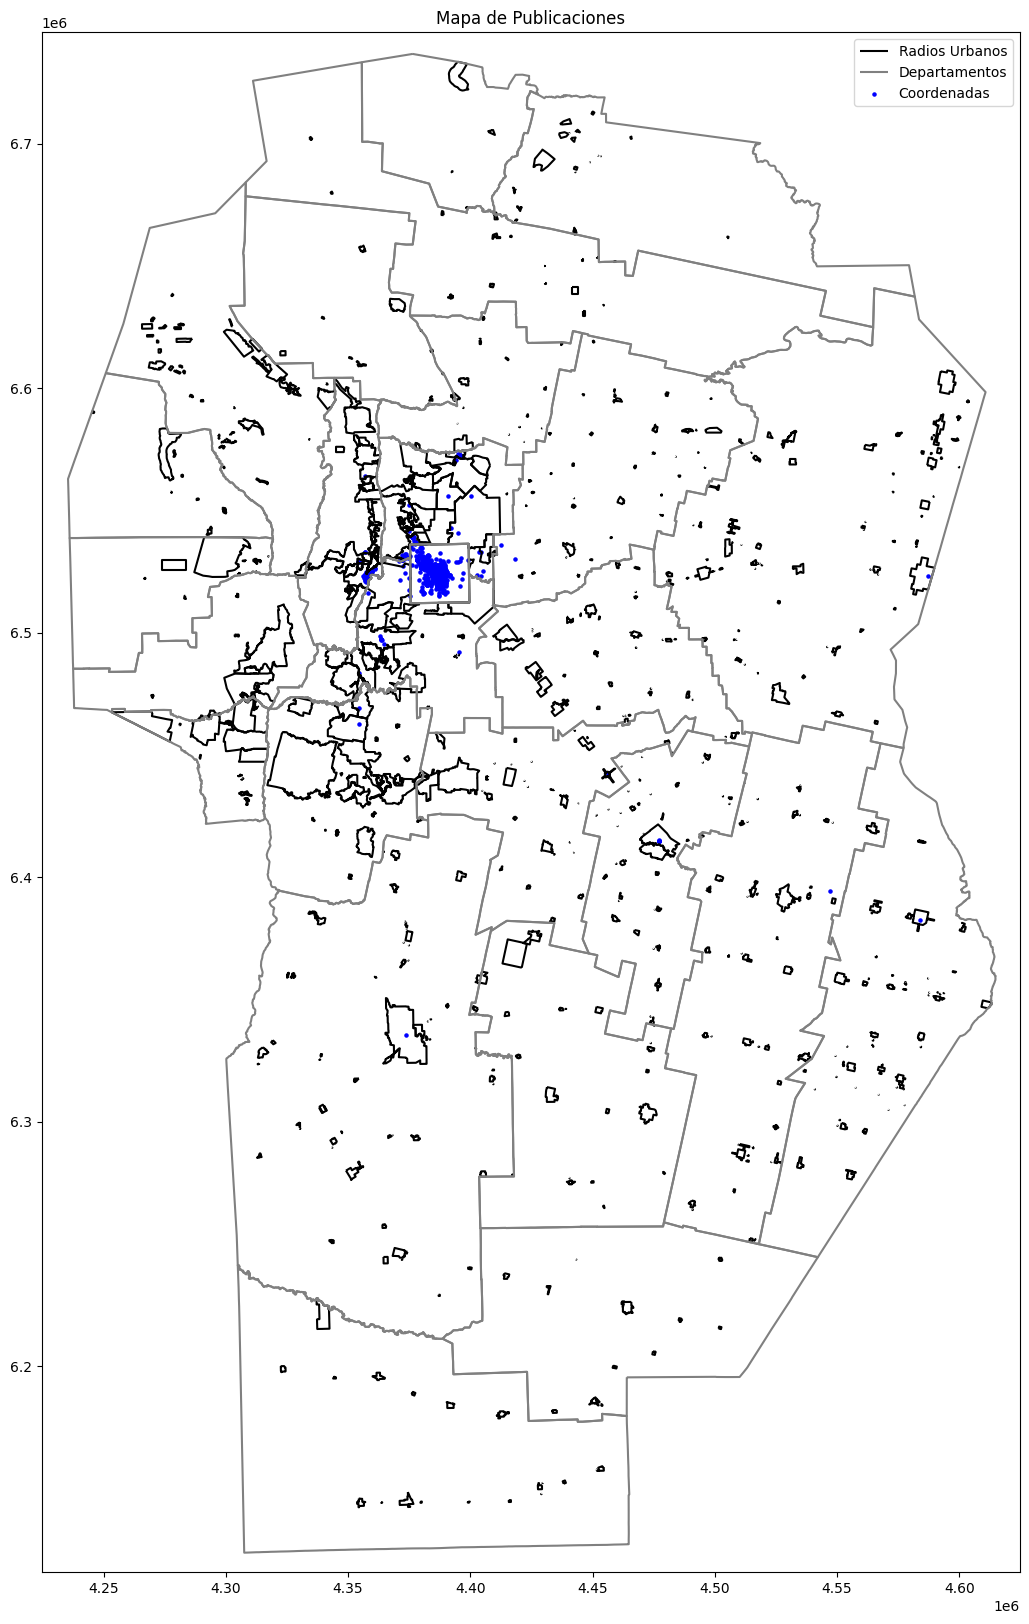

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj

# Define the source and target coordinate systems
source_crs = pyproj.CRS("EPSG:4326")  # WGS84 (latitude and longitude)
target_crs = pyproj.CRS("EPSG:22174")  # POSGAR 98 / Argentina 4
# Create a transformer
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)
longitudes, latitudes = transformer.transform(ubicados['coordY'], ubicados['coordX'])

center = (4424708.768444949, 6445660.828924287)

# Read the shapefiles
radios_urbanos_shapefile = './utils/maps/radios_urbanos.shp'
departamentos_shapefile = './utils/maps/departamentos.shp'

radios_urbanos = gpd.read_file(radios_urbanos_shapefile)
departamentos = gpd.read_file(departamentos_shapefile)

# Create a plot with the boundaries of both shapefiles
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the boundaries of radios_urbanos shapefile
radios_urbanos.boundary.plot(ax=ax, color='black', label='Radios Urbanos')
departamentos.boundary.plot(ax=ax, color='gray', label='Departamentos')

# Plot the southernmost point
ax.scatter(longitudes, latitudes, color='blue', label='Coordenadas', s=5)

map_padding = 350000  # Increase the padding for more zoom-out effect
ax.set_xlim(center[0] - map_padding+150000, center[0] + map_padding-150000)
ax.set_ylim(center[1] - map_padding+20000, center[1] + map_padding-50000)

# Set the title and legend
ax.set_title('Mapa de Publicaciones')
ax.legend()

# Show the plot
plt.show()

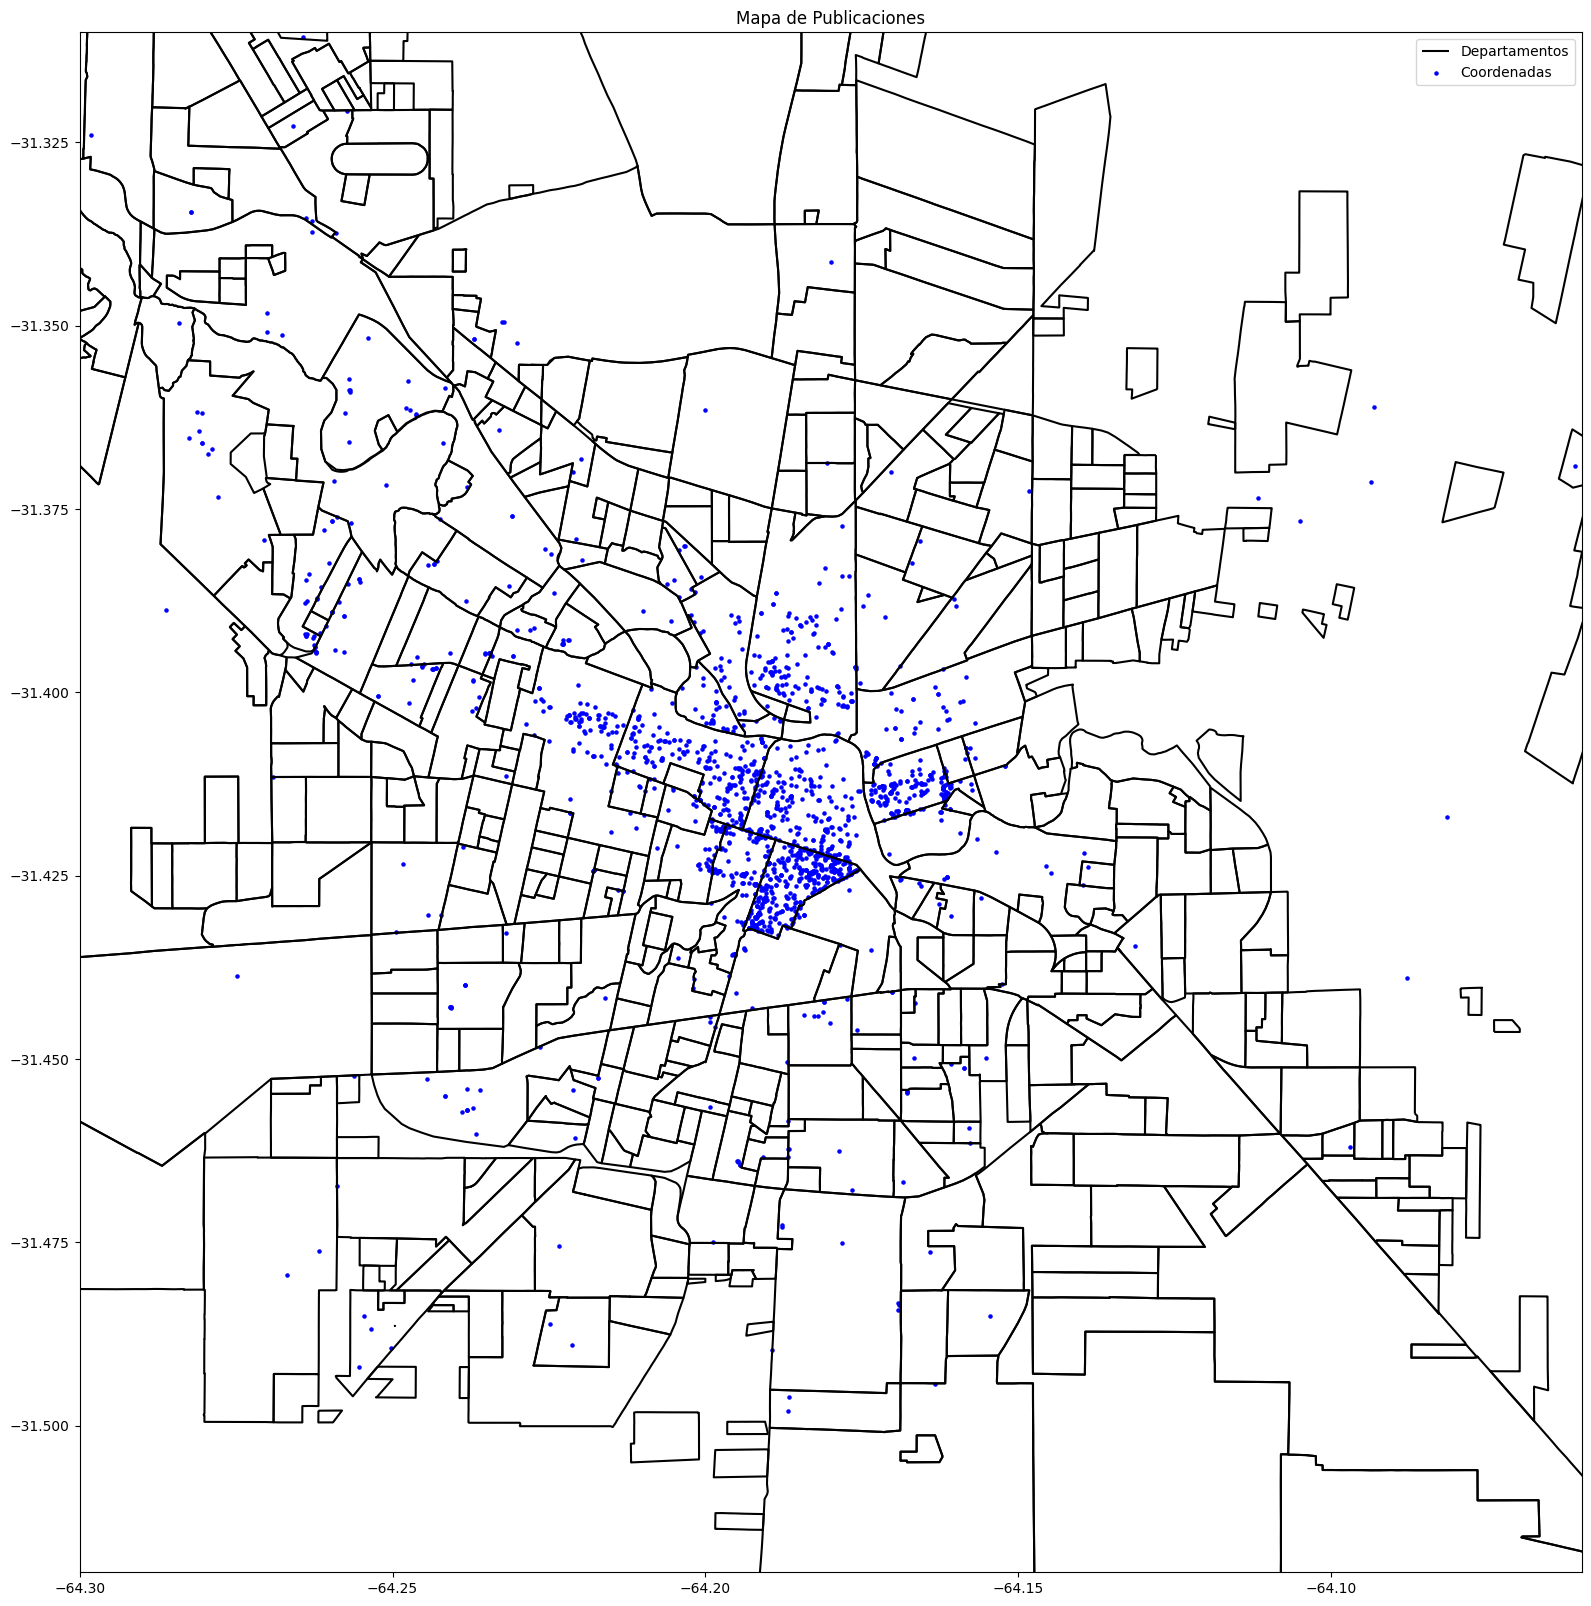

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj

# Define the source and target coordinate systems
source_crs = pyproj.CRS("EPSG:4326")  # WGS84 (latitude and longitude)
# Create a transformer
latitudes = ubicados['coordX']
longitudes = ubicados['coordY']

# Read the shapefiles
barrios_shp = './utils/maps/barrios.shp'
barrios = gpd.read_file(barrios_shp)
center = (-64.18365408774824, -31.41675384652835)


# Create a plot with the boundaries of both shapefiles
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the boundaries of radios_urbanos shapefile
barrios.boundary.plot(ax=ax, color='black', label='Departamentos')

# Plot the transformed points with smaller markers and more transparency
ax.scatter(longitudes, latitudes, color='blue', label='Coordenadas', s=5)

map_padding = 0.15  # Increase the padding for more zoom-out effect
ax.set_xlim(-64.30, -64.06)
ax.set_ylim(-31.52, -31.31)

# Set the title and legend
ax.set_title('Mapa de Publicaciones')
ax.legend()

# Show the plot
plt.show()

In [16]:
particulares = inmuebles_filt.loc[inmuebles_filt['tipoVendedor'] == 'PARTICULAR']
filt = particulares['barrio'].str.contains('MANANTIALES', na=False) & particulares['activo']
particulares.loc[filt]

,id,tipoPropiedad,precioUSD,fechaUltimaActualizacion,tipoVendedor,terrenoTotal,terrenoEdificado,cantDormitorios,cantBanos,cantCochera,barrio,ciudad,coordX,coordY,activo,precio_m2_total,precio_m2_edif
5158,5097213,CASA,93000,2023-07-26,PARTICULAR,180.0,120.0,3.0,2.0,NaN,PRADOS DE MANANTIALES,CORDOBA,NaN,NaN,True,516.666667,775.000000
5181,4739885,CASA,129000,2023-07-26,PARTICULAR,180.0,145.0,3.0,2.0,1.0,MANANTIALES,CORDOBA,NaN,NaN,True,716.666667,889.655172
5199,4824015,CASA,110000,2023-07-26,PARTICULAR,145.0,NaN,3.0,2.0,2.0,PRADOS DE MANANTIALES,CORDOBA,NaN,NaN,True,758.620690,NaN
6827,5057767,CASA,125000,2023-07-19,PARTICULAR,150.0,NaN,3.0,3.0,1.0,MIRADORES DE MANANTIALES,CORDOBA,NaN,NaN,True,833.333333,NaN
8009,5088717,CASA,440000,2023-07-13,PARTICULAR,1000.0,278.0,4.0,3.0,2.0,MANANTIALES,CORDOBA,-31.447729,-64.224572,True,440.000000,1582.733813
8113,5086150,CASA,170000,2023-07-13,PARTICULAR,250.0,180.0,2.0,3.0,2.0,PRADOS DE MANANTIALES,CORDOBA,NaN,NaN,True,680.000000,944.444444
8729,5036123,CASA,130000,2023-07-11,PARTICULAR,166.0,136.0,3.0,3.0,2.0,PRADOS DE MANANTIALES,CORDOBA,-31.467356,-64.258919,True,783.132530,955.882353
10762,5092369,CASA,155000,2023-07-26,PARTICULAR,136.0,NaN,3.0,2.0,2.0,MANANTIALES,CORDOBA,NaN,NaN,True,1139.705882,NaN
